In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import time
import warnings
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from folium import plugins
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import kagglehub
path = kagglehub.dataset_download("dgomonov/new-york-city-airbnb-open-data")
print("Path to dataset files:", path)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
file_path = '/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv'
df = pd.read_csv(file_path)

/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv
/kaggle/input/new-york-city-airbnb-open-data/New_York_City_.png
Path to dataset files: /kaggle/input/new-york-city-airbnb-open-data


In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.647,-73.972,Private room,149,1,9,2018-10-19,0.210,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.754,-73.984,Entire home/apt,225,1,45,2019-05-21,0.380,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.809,-73.942,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.685,-73.960,Entire home/apt,89,1,270,2019-07-05,4.640,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.799,-73.944,Entire home/apt,80,10,9,2018-11-19,0.100,1,0


In [4]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [5]:
drop_list  = ['id', 'host_id', 'host_name','last_review']

In [6]:
df.drop(drop_list, axis=1, inplace=True)

In [7]:
df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.647,-73.972,Private room,149,1,9,0.210,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.754,-73.984,Entire home/apt,225,1,45,0.380,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.809,-73.942,Private room,150,3,0,NaN,1,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.685,-73.960,Entire home/apt,89,1,270,4.640,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.799,-73.944,Entire home/apt,80,10,9,0.100,1,0


In [8]:
# from ydata_profiling import ProfileReport
# df.profile_report()

### Geographic Locations

In [9]:
Long=-73.80
Lat=40.80

locations = list(zip(df.latitude, df.longitude))

map1 = folium.Map(location=[Lat,Long], zoom_start=9)

FastMarkerCluster(data=locations).add_to(map1)

map1

In [10]:
df_filtered = df[['latitude', 'longitude', 'price']].dropna()
df_filtered = df_filtered[df_filtered['price'] > 0]
df_filtered['price'] = df_filtered['price'].clip(upper=df_filtered['price'].quantile(0.95))
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
heat_data = df_filtered[['latitude', 'longitude', 'price']]
HeatMap(heat_data, radius=10, max_zoom=13).add_to(nyc_map)
nyc_map


In [11]:
df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.647,-73.972,Private room,149,1,9,0.210,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.754,-73.984,Entire home/apt,225,1,45,0.380,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.809,-73.942,Private room,150,3,0,NaN,1,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.685,-73.960,Entire home/apt,89,1,270,4.640,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.799,-73.944,Entire home/apt,80,10,9,0.100,1,0


In [12]:
# df.fillna({'reviews_per_month':0}, inplace=True)

In [13]:
dff = df[["reviews_per_month"]]
dff.head()

,reviews_per_month
0,0.210
1,0.380
2,NaN
3,4.640
4,0.100


In [14]:
# RobustScaler performs scaling based on the median and interquartile range (IQR).
# More resistant to outliers than StandardScaler or MinMaxScaler.
rs = RobustScaler()
dff = pd.DataFrame(rs.fit_transform(dff), columns=dff.columns)
dff.head()

,reviews_per_month
0,-0.279
1,-0.186
2,NaN
3,2.142
4,-0.339


In [15]:
# Filling NaN using KNN
dff = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(dff), columns = dff.columns)
dff.head()

,reviews_per_month
0,-0.279
1,-0.186
2,0.357
3,2.142
4,-0.339


In [16]:
dff = pd.DataFrame(rs.inverse_transform(dff), columns=dff.columns)
df[["reviews_per_month"]] = dff
df.head(10)

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.647,-73.972,Private room,149,1,9,0.210,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.754,-73.984,Entire home/apt,225,1,45,0.380,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.809,-73.942,Private room,150,3,0,1.373,1,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.685,-73.960,Entire home/apt,89,1,270,4.640,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.799,-73.944,Entire home/apt,80,10,9,0.100,1,0
5,Large Cozy 1 BR Apartment In Midtown East,Manhattan,Murray Hill,40.748,-73.975,Entire home/apt,200,3,74,0.590,1,129
6,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,40.687,-73.956,Private room,60,45,49,0.400,1,0
7,Large Furnished Room Near B'way,Manhattan,Hell's Kitchen,40.765,-73.985,Private room,79,2,430,3.470,1,220
8,Cozy Clean Guest Room - Family Apt,Manhattan,Upper West Side,40.802,-73.967,Private room,79,2,118,0.990,1,0
9,Cute & Cozy Lower East Side 1 bdrm,Manhattan,Chinatown,40.713,-73.990,Entire home/apt,150,1,160,1.330,4,188


In [17]:
df.isnull().sum()

name                              16
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

In [18]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] 
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car] 
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"] 
    num_cols = [col for col in num_cols if col not in num_but_cat] 
    print(f"Observations: {dataframe.shape[0]}") 
    print(f"Variables: {dataframe.shape[1]}") 
    print(f'cat_cols: {len(cat_cols)}') 
    print(f'num_cols: {len(num_cols)}') 
    print(f'cat_but_car: {len(cat_but_car)}') 
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [19]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 48895
Variables: 12
cat_cols: 2
num_cols: 8
cat_but_car: 2
num_but_cat: 0


In [20]:
cat_cols


['neighbourhood_group', 'room_type']

In [21]:
num_cols

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [22]:
cat_but_car

['name', 'neighbourhood']

In [23]:
num_but_cat

[]

Brooklyn and Manhattan have the highest concentration of listings.
Queens has a moderate density, while Bronx and Staten Island have fewer listings.

Most listings are entire homes/apartments, followed by private rooms. Shared rooms have the lowest prices.

                     neighbourhood_group  Ratio
neighbourhood_group                            
Manhattan                          21661 44.301
Brooklyn                           20104 41.117
Queens                              5666 11.588
Bronx                               1091  2.231
Staten Island                        373  0.763


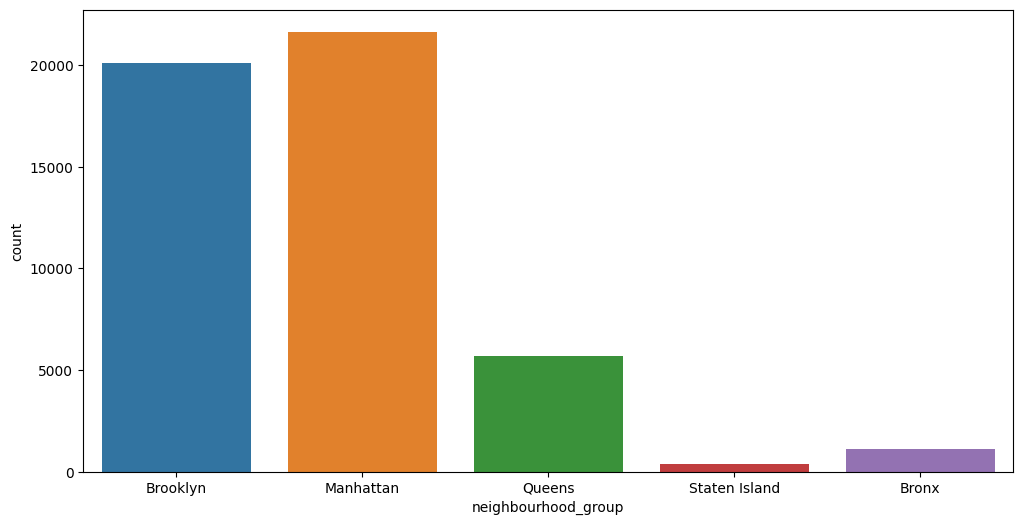

                 room_type  Ratio
room_type                        
Entire home/apt      25409 51.966
Private room         22326 45.661
Shared room           1160  2.372


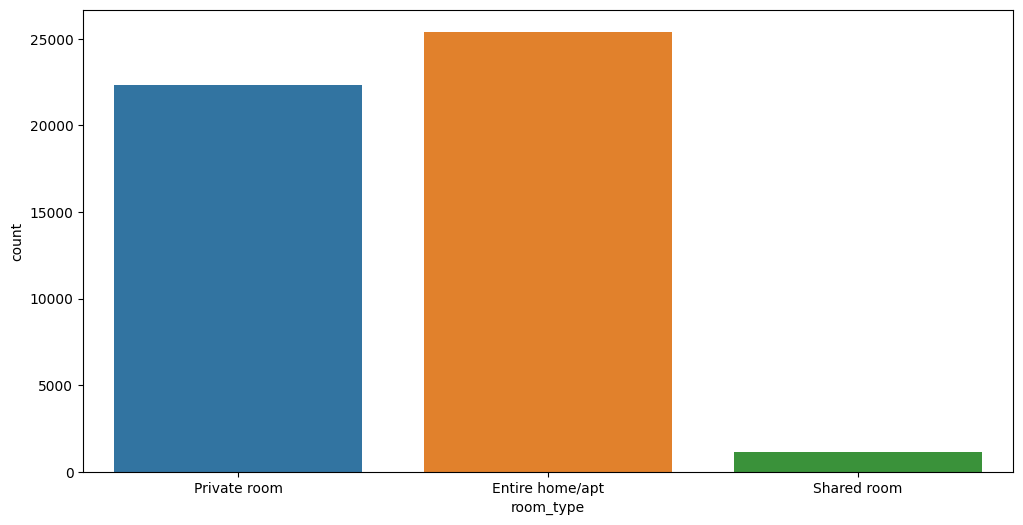

In [24]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    if plot:
        plt.figure(figsize=(12,6))
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [25]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.25, 0.50, 0.75, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

In [26]:
# for col in num_cols:
#     num_summary(df, col, plot=True)

Manhattan dominates pricing due to its premium location. Bronx and Queens are more affordable, Brooklyn and Staten Island are  mid-range.

Entire home/apartment listings are the most expensive. Private rooms have an average price, and Shared rooms are the cheapest.

In [27]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=categorical_col, y=target, data=dataframe)
        plt.show(block=True)

                     TARGET_MEAN
neighbourhood_group             
Bronx                     87.497
Brooklyn                 124.383
Manhattan                196.876
Queens                    99.518
Staten Island            114.812




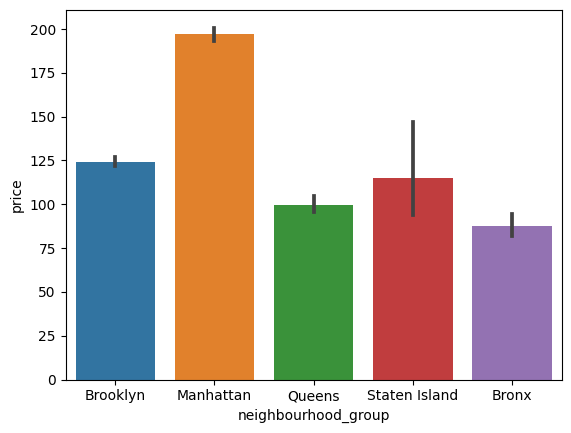

                 TARGET_MEAN
room_type                   
Entire home/apt      211.794
Private room          89.781
Shared room           70.128




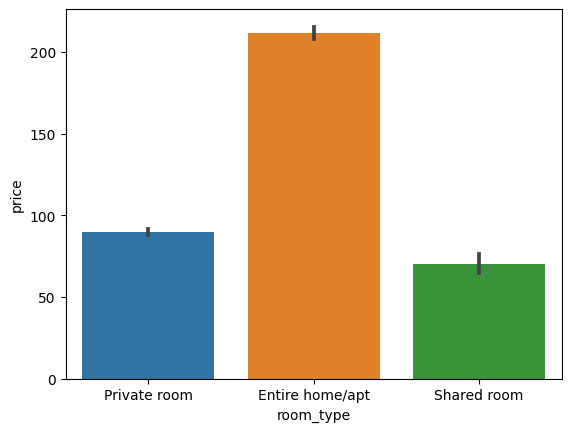

In [28]:
for col in cat_cols:
    target_summary_with_cat(df, 'price', col, plot=True)

In [29]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(pd.DataFrame({numerical_col+'_mean': dataframe.groupby(target)[numerical_col].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)

In [30]:
for col in num_cols:
    target_summary_with_cat(df, 'price', col, plot=False) 

          TARGET_MEAN
latitude             
40.500        110.000
40.506         75.000
40.507        100.000
40.509        299.000
40.509         85.000
...               ...
40.908         53.000
40.912         40.000
40.912         50.000
40.912         40.000
40.913         40.000

[19048 rows x 1 columns]


           TARGET_MEAN
longitude             
-74.244         70.000
-74.243        100.000
-74.241        110.000
-74.240        299.000
-74.239         85.000
...                ...
-73.719         32.000
-73.718        180.000
-73.718         42.000
-73.717        240.000
-73.713         65.000

[14718 rows x 1 columns]


       TARGET_MEAN
price             
0            0.000
10          10.000
11          11.000
12          12.000
13          13.000
...            ...
7703      7703.000
8000      8000.000
8500      8500.000
9999      9999.000
10000    10000.000

[674 rows x 1 columns]


                TARGET_MEAN
minimum_nights             
1                   142.023
2 

### Correlation Analysis
Listings with higher availability tend to be booked more often.

More frequent bookings lead to more reviews.

Listings with more bookings generate higher minimum income.

Longer stays (minimum_nights) correlate with more total booked days

In [31]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (12, 12)})
        sns.heatmap(corr, cmap="RdBu", annot=True, fmt=".2f") 
        plt.show()
    return drop_list

In [32]:
corr = df[num_cols].corr()
corr

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000,0.085,0.034,0.025,-0.015,-0.009,0.020,-0.011
longitude,0.085,1.000,-0.150,-0.063,0.059,0.132,-0.115,0.083
price,0.034,-0.150,1.000,0.043,-0.048,-0.022,0.057,0.082
minimum_nights,0.025,-0.063,0.043,1.000,-0.080,-0.092,0.128,0.144
number_of_reviews,-0.015,0.059,-0.048,-0.080,1.000,0.530,-0.072,0.172
reviews_per_month,-0.009,0.132,-0.022,-0.092,0.530,1.000,-0.007,0.163
calculated_host_listings_count,0.020,-0.115,0.057,0.128,-0.072,-0.007,1.000,0.226
availability_365,-0.011,0.083,0.082,0.144,0.172,0.163,0.226,1.000


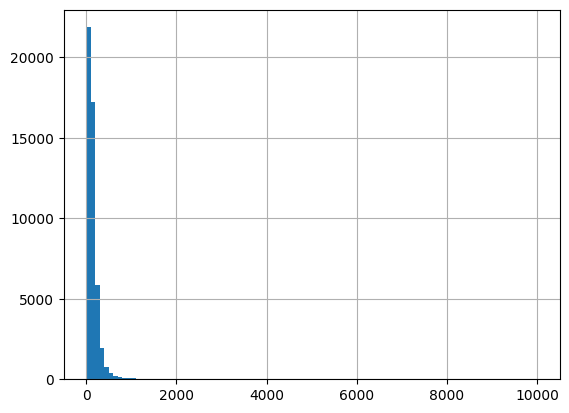

In [33]:
df["price"].hist(bins=100)
plt.show(block=True)

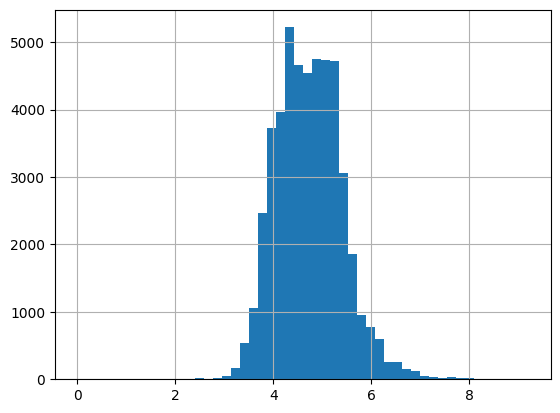

In [34]:
np.log1p(df['price']).hist(bins=50)
plt.show(block=True)

### Visualizing Location Data Based on Neighbourhood Group and Room Type

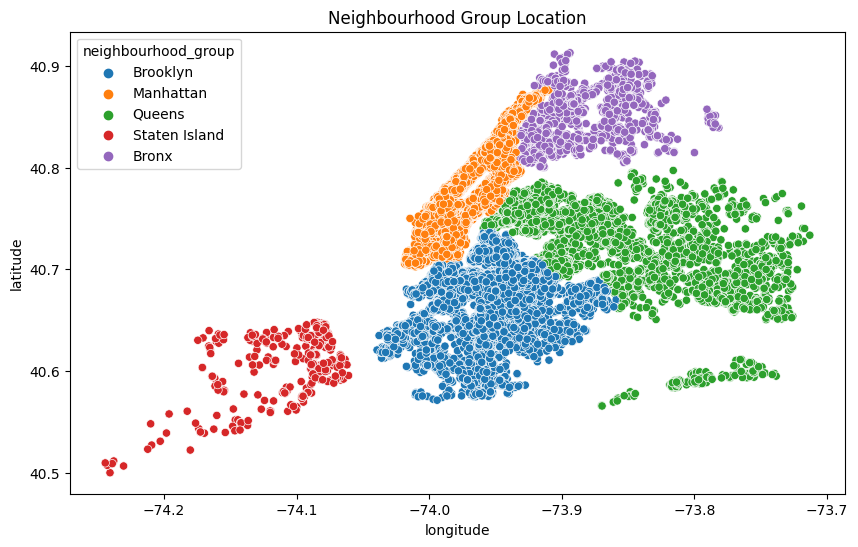

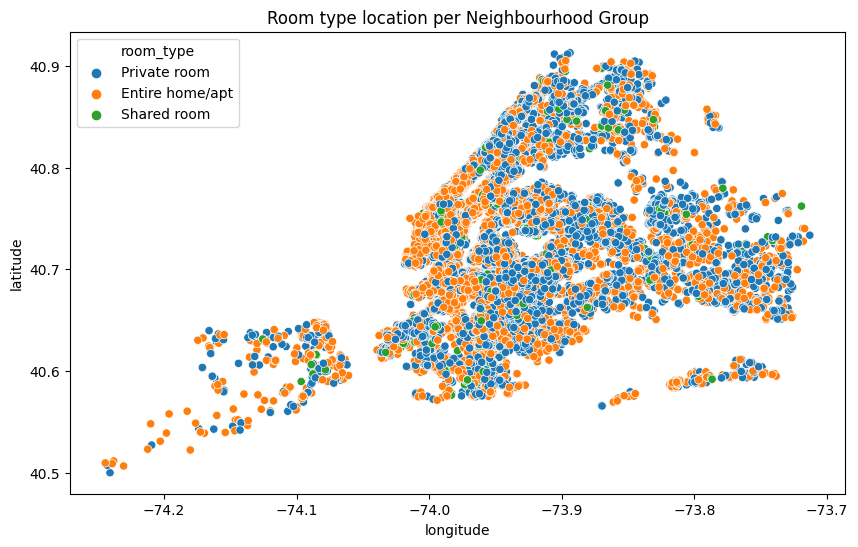

In [35]:
title = 'Neighbourhood Group Location'
plt.figure(figsize=(10,6))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group', data=df).set_title(title)
plt.ioff()

title = 'Room type location per Neighbourhood Group'
plt.figure(figsize=(10,6))
sns.scatterplot(x='longitude', y='latitude', hue='room_type', data=df).set_title(title)
plt.ioff()

### Price Distribution by Room Type in Neighbourhood Groups
Entire home/apartment listings dominate Manhattan. Private rooms are more widespread across all areas. Shared rooms are less common.

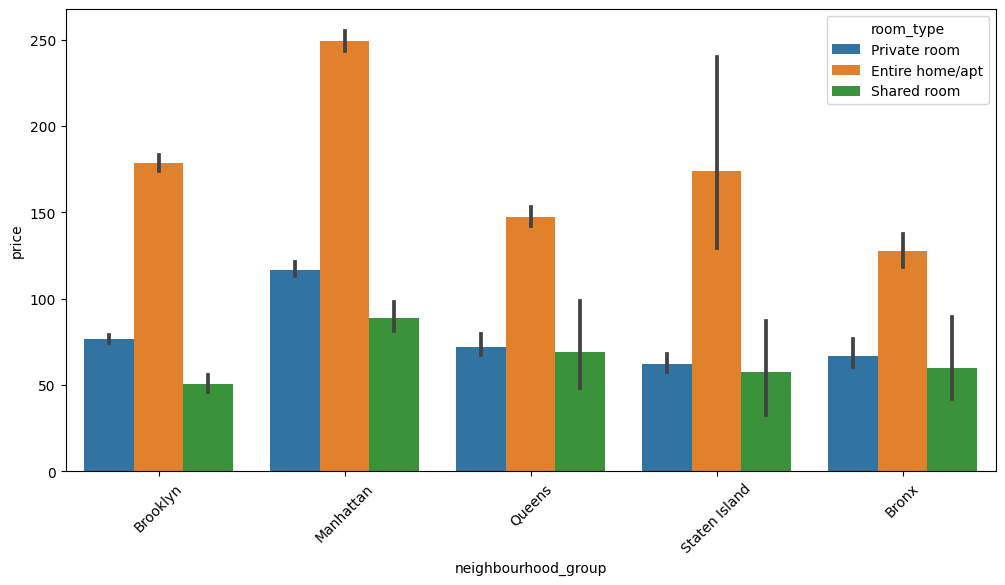

In [36]:
plt.figure(figsize=(12,6))
sns.barplot(x = "neighbourhood_group", y = "price", hue = "room_type", data = df)
plt.xticks(rotation=45)
plt.show()

### Comparative Display of Median Monthly Reviews by Neighbourhood Group

Bronx, Queens, and Staten Island have the highest median reviews per month (~1.75).

Brooklyn and Manhattan have lower review rates (~1.25).

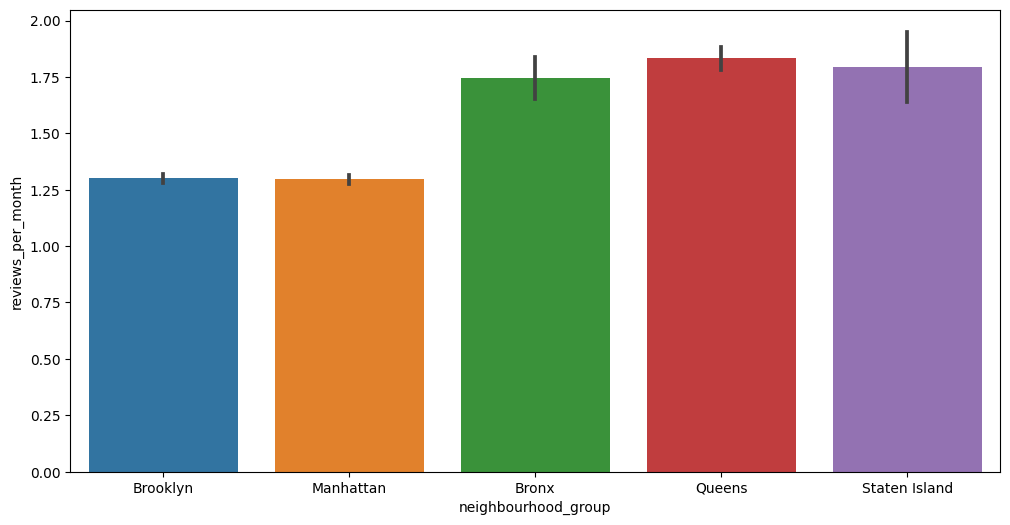

In [37]:
plt.figure(figsize=(12,6))
result = df.groupby(["neighbourhood_group"])['reviews_per_month'].aggregate(np.median).reset_index().sort_values('reviews_per_month')
sns.barplot(x='neighbourhood_group', y="reviews_per_month", data=df, order=result['neighbourhood_group'])
plt.show()

### Comparison of Minimum Stay Nights by Neighbourhood Group

Manhattan has the highest median minimum stay (~6-7 nights).

Brooklyn, Queens, and Staten Island have moderate minimum stays (~4-5 nights).

Bronx has the lowest minimum stay (~3 nights).

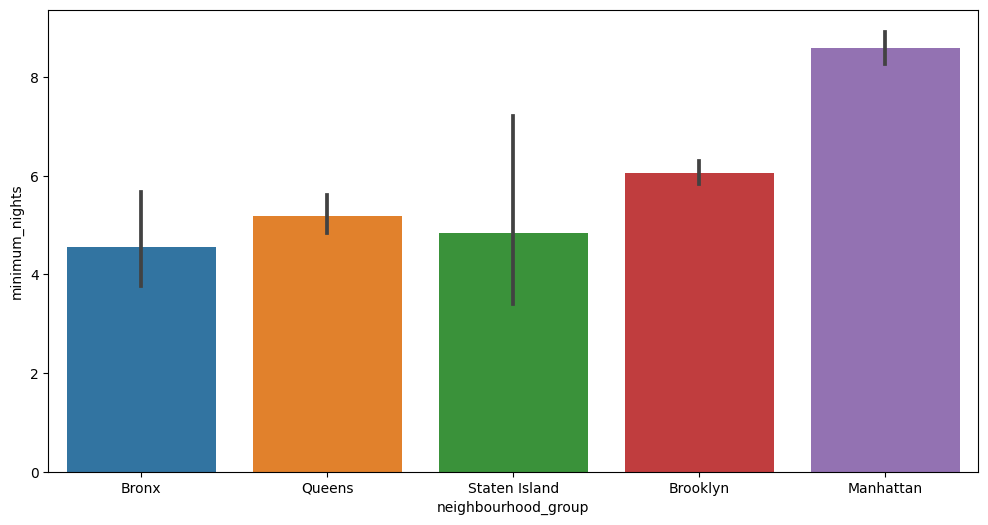

In [38]:
plt.figure(figsize=(12,6))
result = df.groupby(["neighbourhood_group"])['minimum_nights'].aggregate(np.median).reset_index().sort_values('minimum_nights')
sns.barplot(x='neighbourhood_group', y="minimum_nights", data=df, order=result['neighbourhood_group'])
plt.show()

### Comparison of Number of Reviews by Neighbourhood Group
Queens has the highest median number of reviews (~30).

Brooklyn, Bronx, and Staten Island follow with ~25 reviews on average.

Manhattan has the lowest median number of reviews (~22-23) possibly due to higher prices and shorter stays.

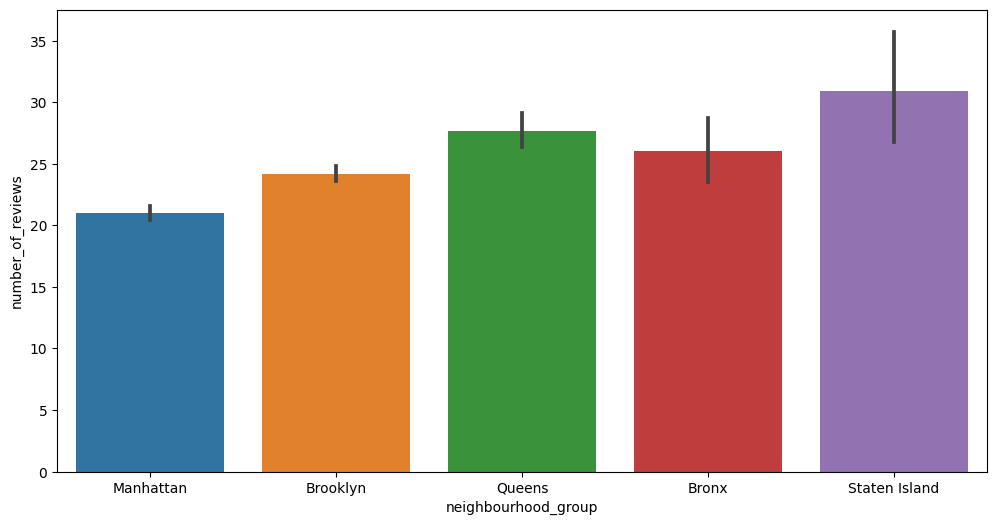

In [39]:
plt.figure(figsize=(12,6))
result = df.groupby(["neighbourhood_group"])['number_of_reviews'].aggregate(np.median).reset_index().sort_values('number_of_reviews')
sns.barplot(x='neighbourhood_group', y="number_of_reviews", data=df, order=result['neighbourhood_group'])
plt.show()

### Comparison of Host Listing Counts by Neighbourhood Group

Manhattan hosts tend to have the highest number of listings per host (~12).

Other boroughs (Bronx, Brooklyn, Queens, Staten Island) have much fewer (~2-4 listings per host).

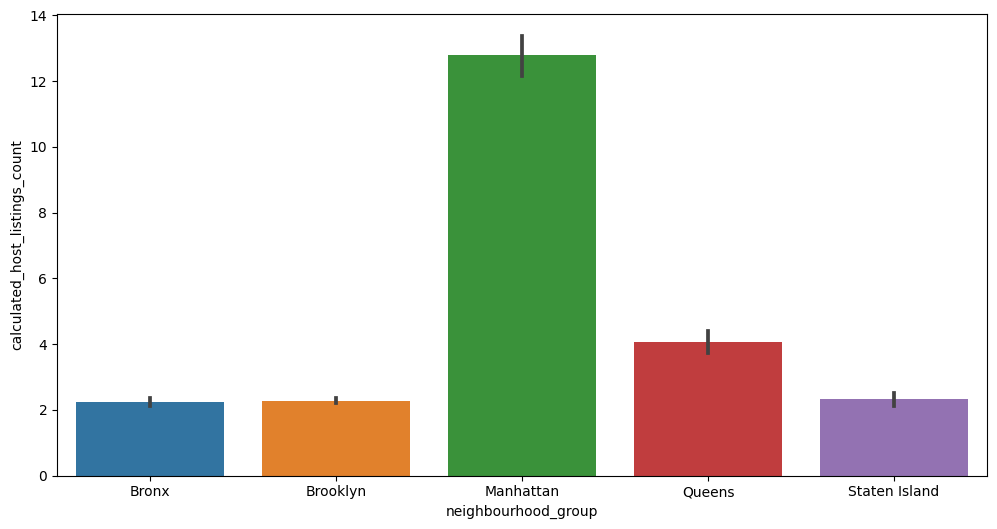

In [40]:
plt.figure(figsize=(12,6))
result = df.groupby(["neighbourhood_group"])['calculated_host_listings_count'].aggregate(np.median).reset_index().sort_values('calculated_host_listings_count')
sns.barplot(x='neighbourhood_group', y="calculated_host_listings_count", data=df, order=result['neighbourhood_group'])
plt.show()

### Comparison of Yearly Availability by Neighbourhood Group
Staten Island has the highest availability (close to 200 days per year).

Bronx and Queens also have high availability, while Brooklyn and Manhattan have lower availability (closer to 125-150 days).

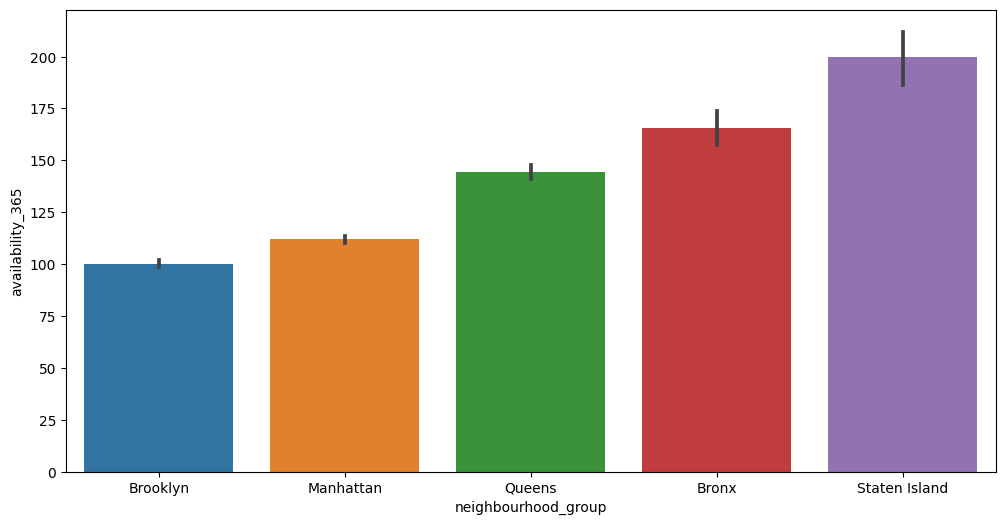

In [41]:
plt.figure(figsize=(12,6))
result = df.groupby(["neighbourhood_group"])['availability_365'].aggregate(np.median).reset_index().sort_values('availability_365')
sns.barplot(x='neighbourhood_group', y="availability_365", data=df, order=result['neighbourhood_group']) 
plt.show()

### Comparison of Number of Reviews by Room Type¶
Private rooms and entire apartments have the most reviews (~22-24 median reviews). 

Shared rooms have fewer reviews (~15-18 median reviews)

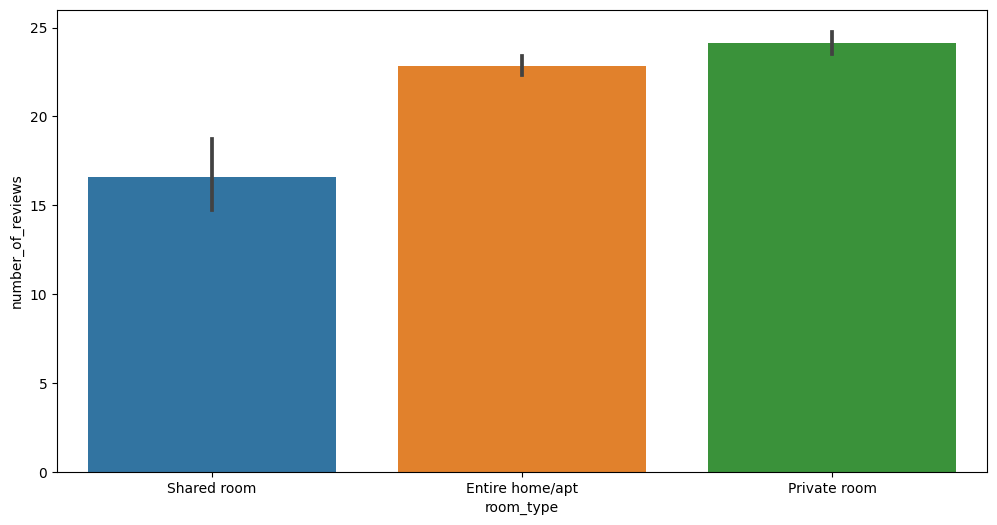

In [42]:
plt.figure(figsize=(12,6))
result = df.groupby(["room_type"])['number_of_reviews'].aggregate(np.median).reset_index().sort_values('number_of_reviews')
sns.barplot(x='room_type', y="number_of_reviews", data=df, order=result['room_type'])
plt.show()

### Comparison of Monthly Reviews by Room Type

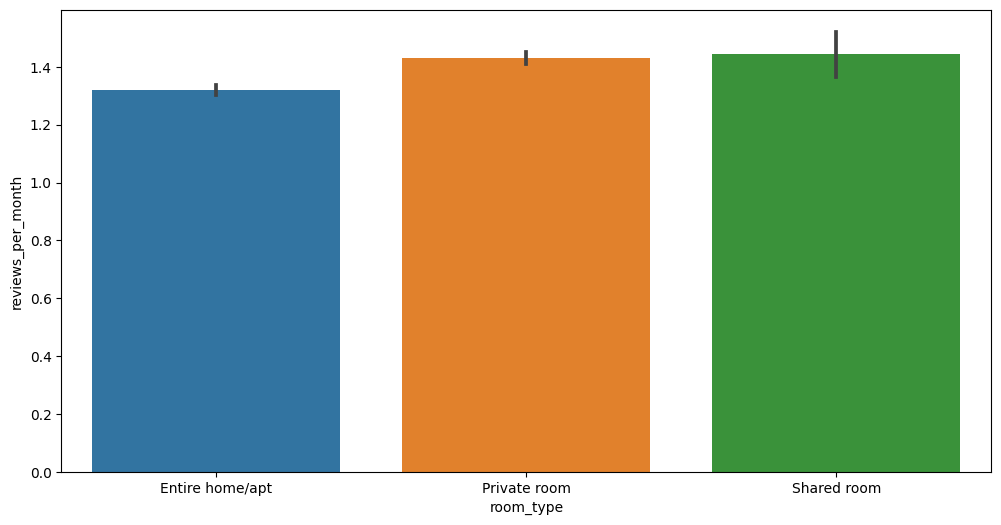

In [43]:
plt.figure(figsize=(12,6))
result = df.groupby(["room_type"])['reviews_per_month'].aggregate(np.median).reset_index().sort_values('reviews_per_month')
sns.barplot(x='room_type', y="reviews_per_month", data=df, order=result['room_type'])
plt.show()

### Comparison of Host Listing Counts by Room Type
Entire home/apartments have the highest number of listings per host (~10). 

Shared and private rooms have significantly fewer listings per host

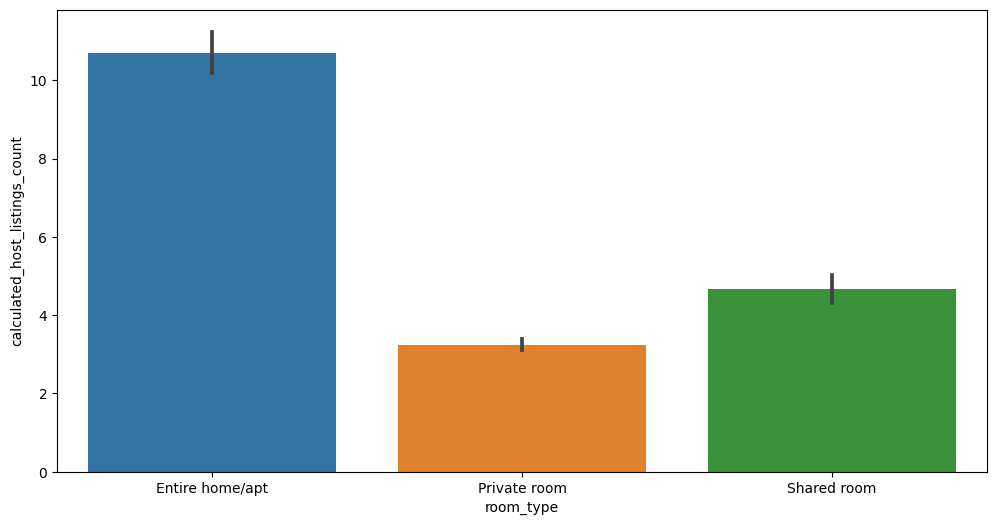

In [44]:
plt.figure(figsize=(12,6))
result = df.groupby(["room_type"])['calculated_host_listings_count'].aggregate(np.median).reset_index().sort_values('calculated_host_listings_count')
sns.barplot(x='room_type', y="calculated_host_listings_count", data=df, order=result['room_type'])
plt.show()

### Comparison of Yearly Availability by Room Type
Shared rooms tend to be available for longer durations. Entire homes and private rooms may have more seasonal availabilit

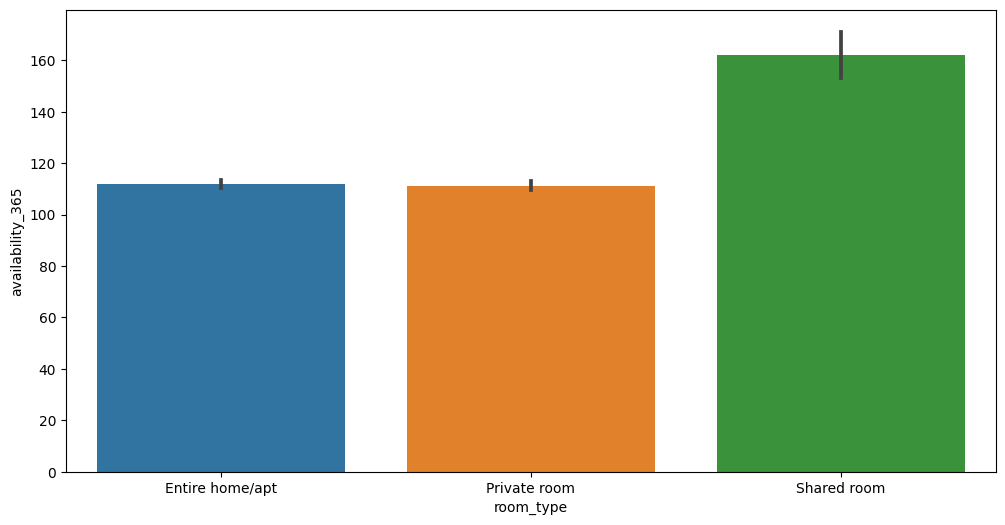

In [45]:
plt.figure(figsize=(12,6))
result = df.groupby(["room_type"])['availability_365'].aggregate(np.median).reset_index().sort_values('availability_365')
sns.barplot(x='room_type', y="availability_365", data=df, order=result['room_type'])
plt.show()

### Outliers Analysis

In [46]:
df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.647,-73.972,Private room,149,1,9,0.210,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.754,-73.984,Entire home/apt,225,1,45,0.380,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.809,-73.942,Private room,150,3,0,1.373,1,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.685,-73.960,Entire home/apt,89,1,270,4.640,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.799,-73.944,Entire home/apt,80,10,9,0.100,1,0


In [47]:
drop_list_2 = ['name','neighbourhood']
df.drop(drop_list_2, axis=1, inplace=True)
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.647,-73.972,Private room,149,1,9,0.210,6,365
1,Manhattan,40.754,-73.984,Entire home/apt,225,1,45,0.380,2,355
2,Manhattan,40.809,-73.942,Private room,150,3,0,1.373,1,365
3,Brooklyn,40.685,-73.960,Entire home/apt,89,1,270,4.640,1,194
4,Manhattan,40.799,-73.944,Entire home/apt,80,10,9,0.100,1,0


In [48]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    return temp_df

In [49]:
rare_encoder(df, 0.01)

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.647,-73.972,Private room,149,1,9,0.210,6,365
1,Manhattan,40.754,-73.984,Entire home/apt,225,1,45,0.380,2,355
2,Manhattan,40.809,-73.942,Private room,150,3,0,1.373,1,365
3,Brooklyn,40.685,-73.960,Entire home/apt,89,1,270,4.640,1,194
4,Manhattan,40.799,-73.944,Entire home/apt,80,10,9,0.100,1,0
...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,40.679,-73.950,Private room,70,2,0,1.373,2,9
48891,Brooklyn,40.702,-73.933,Private room,40,4,0,1.373,2,36
48892,Manhattan,40.815,-73.949,Entire home/apt,115,10,0,1.373,1,27
48893,Manhattan,40.758,-73.991,Shared room,55,1,0,1.373,6,2


In [50]:
df['NEW_total_cost'] = df['price'] * df['minimum_nights']
df['NEW_estimated_listed_months'] = df['number_of_reviews'] / df['reviews_per_month']
df['NEW_availability_ratio'] = df['availability_365'] / 365
df['NEW_daily_average_reviews'] = df['reviews_per_month'] / 30
df['NEW_annual_income'] = df['price'] * df['availability_365']
df['NEW_average_stay_duration'] = df['number_of_reviews'] / df['reviews_per_month']
df['NEW_days_booked'] = 365 - df['availability_365']
df['NEW_minimum_income'] = df['price'] * df['minimum_nights']

In [51]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   latitude                        48895 non-null  float64
 2   longitude                       48895 non-null  float64
 3   room_type                       48895 non-null  object 
 4   price                           48895 non-null  int64  
 5   minimum_nights                  48895 non-null  int64  
 6   number_of_reviews               48895 non-null  int64  
 7   reviews_per_month               48895 non-null  float64
 8   calculated_host_listings_count  48895 non-null  int64  
 9   availability_365                48895 non-null  int64  
 10  NEW_total_cost                  48895 non-null  int64  
 11  NEW_estimated_listed_months     48895 non-null  float64
 12  NEW_availability_ratio          

In [52]:
# cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

In [53]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
df = one_hot_encoder(df, cat_cols, drop_first=True)
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,NEW_total_cost,NEW_estimated_listed_months,NEW_availability_ratio,NEW_daily_average_reviews,NEW_annual_income,NEW_average_stay_duration,NEW_days_booked,NEW_minimum_income,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
0,40.647,-73.972,149,1,9,0.210,6,365,149,42.857,1.000,0.007,54385,42.857,0,149,True,False,False,False,True,False
1,40.754,-73.984,225,1,45,0.380,2,355,225,118.421,0.973,0.013,79875,118.421,10,225,False,True,False,False,False,False
2,40.809,-73.942,150,3,0,1.373,1,365,450,0.000,1.000,0.046,54750,0.000,0,450,False,True,False,False,True,False
3,40.685,-73.960,89,1,270,4.640,1,194,89,58.190,0.532,0.155,17266,58.190,171,89,True,False,False,False,False,False
4,40.799,-73.944,80,10,9,0.100,1,0,800,90.000,0.000,0.003,0,90.000,365,800,False,True,False,False,False,False


In [54]:
num_cols = [col for col in num_cols if col not in ["price"]]
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [55]:
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '')
df.columns = df.columns.str.lower()
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,new_total_cost,new_estimated_listed_months,new_availability_ratio,new_daily_average_reviews,new_annual_income,new_average_stay_duration,new_days_booked,new_minimum_income,neighbourhood_group_brooklyn,neighbourhood_group_manhattan,neighbourhood_group_queens,neighbourhood_group_staten_island,room_type_private_room,room_type_shared_room
0,-1.035,-0.357,149,-0.500,0.174,-0.777,5.000,1.410,149,42.857,1.000,0.007,54385,42.857,0,149,True,False,False,False,True,False
1,0.418,-0.600,225,-0.500,1.739,-0.646,1.000,1.366,225,118.421,0.973,0.013,79875,118.421,10,225,False,True,False,False,False,False
2,1.177,0.294,150,0.000,-0.217,0.118,0.000,1.410,450,0.000,1.000,0.046,54750,0.000,0,450,False,True,False,False,True,False
3,-0.519,-0.087,89,-0.500,11.522,2.631,0.000,0.656,89,58.190,0.532,0.155,17266,58.190,171,89,True,False,False,False,False,False
4,1.033,0.250,80,1.750,0.174,-0.862,0.000,-0.198,800,90.000,0.000,0.003,0,90.000,365,800,False,True,False,False,False,False


### Creating Model

In [56]:
y = df["price"]
X = df.drop(["price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   latitude                           48895 non-null  float64
 1   longitude                          48895 non-null  float64
 2   price                              48895 non-null  int64  
 3   minimum_nights                     48895 non-null  float64
 4   number_of_reviews                  48895 non-null  float64
 5   reviews_per_month                  48895 non-null  float64
 6   calculated_host_listings_count     48895 non-null  float64
 7   availability_365                   48895 non-null  float64
 8   new_total_cost                     48895 non-null  int64  
 9   new_estimated_listed_months        48895 non-null  float64
 10  new_availability_ratio             48895 non-null  float64
 11  new_daily_average_reviews          48895 non-null  flo

RMSE: 150.0074 (LR)
R^2 Score: 0.5444 (LR)
MAE: 48.2368 (LR)
Execution Time: 0.28 seconds

RMSE: 145.601 (KNN)
R^2 Score: 0.582 (KNN)
MAE: 42.0393 (KNN)
Execution Time: 4.67 seconds

RMSE: 76.6401 (CART)
R^2 Score: 0.9623 (CART)
MAE: 2.7821 (CART)
Execution Time: 3.26 seconds

RMSE: 67.4017 (RF)
R^2 Score: 0.9331 (RF)
MAE: 2.4958 (RF)
Execution Time: 208.53 seconds

RMSE: 65.3114 (GBM)
R^2 Score: 0.9226 (GBM)
MAE: 17.4208 (GBM)
Execution Time: 62.05 seconds

RMSE: 110.9039 (XGBoost)
R^2 Score: 0.8503 (XGBoost)
MAE: 6.1114 (XGBoost)
Execution Time: 2.67 seconds

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3370
[LightGBM] [Info] Number of data points in the train set: 39116, number of used features: 21
[LightGBM] [Info] Start training from score 153.483357
[LightGBM] [Info] Auto-c

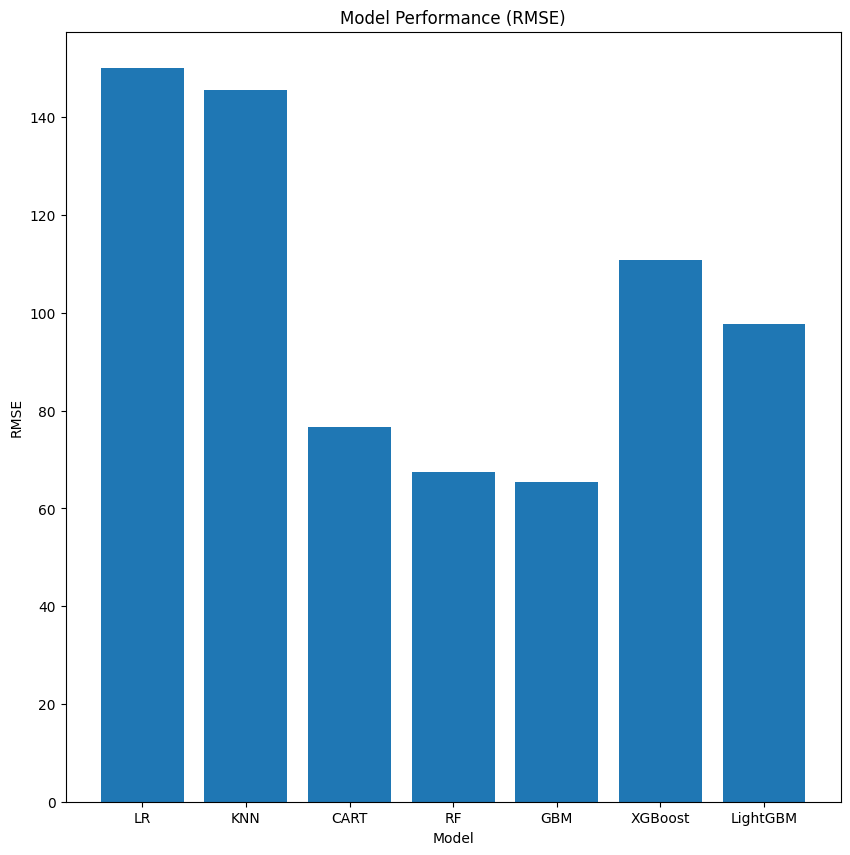

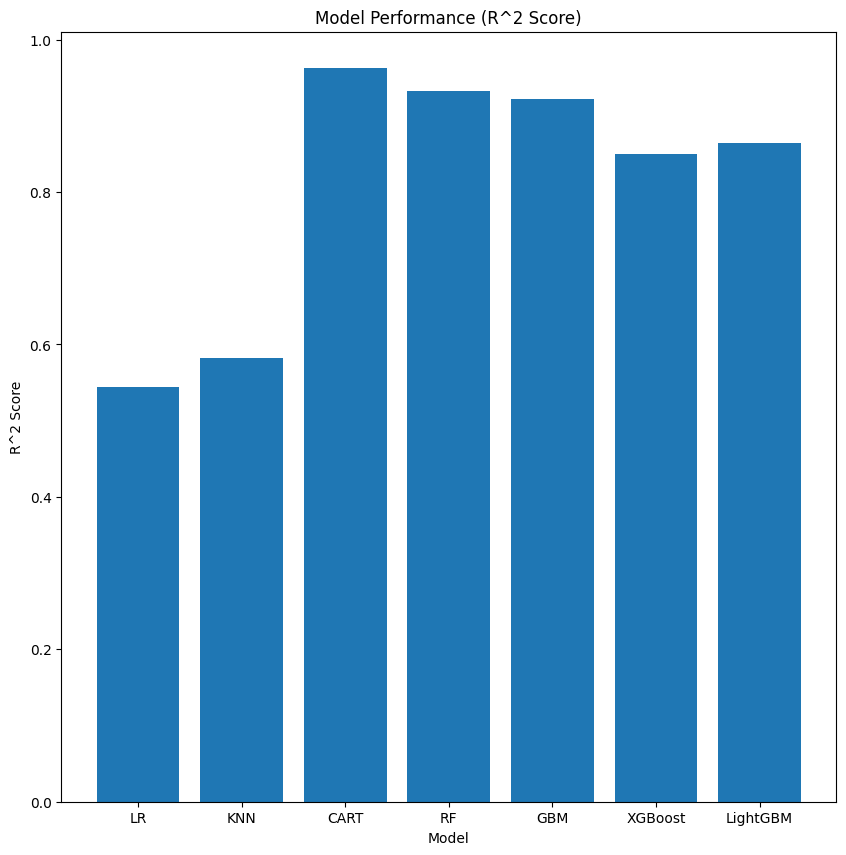

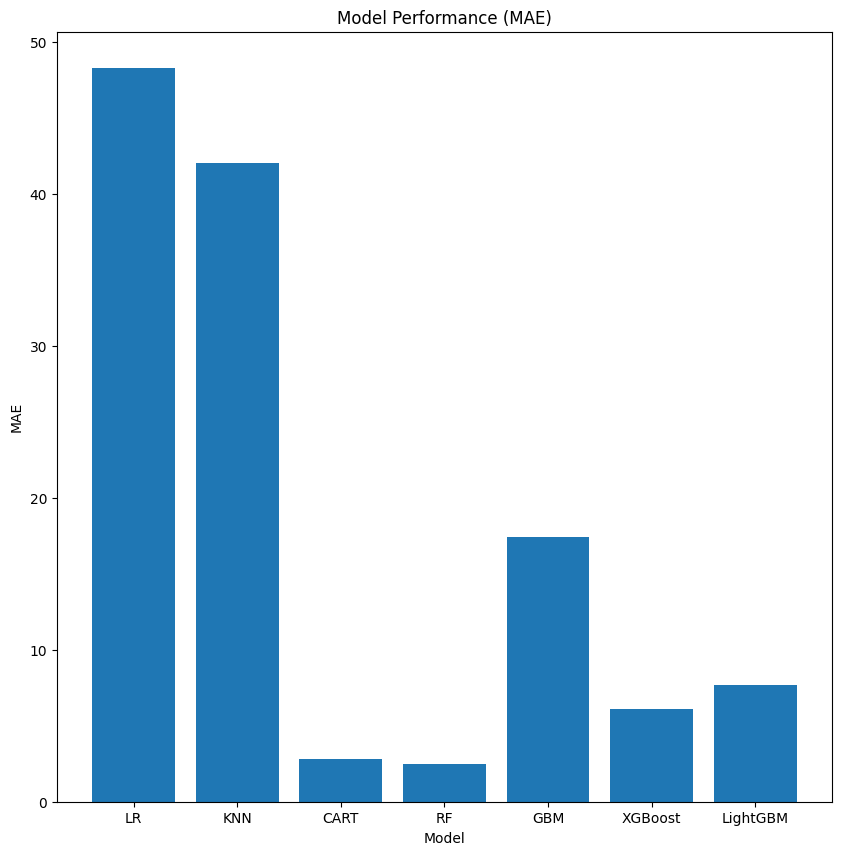

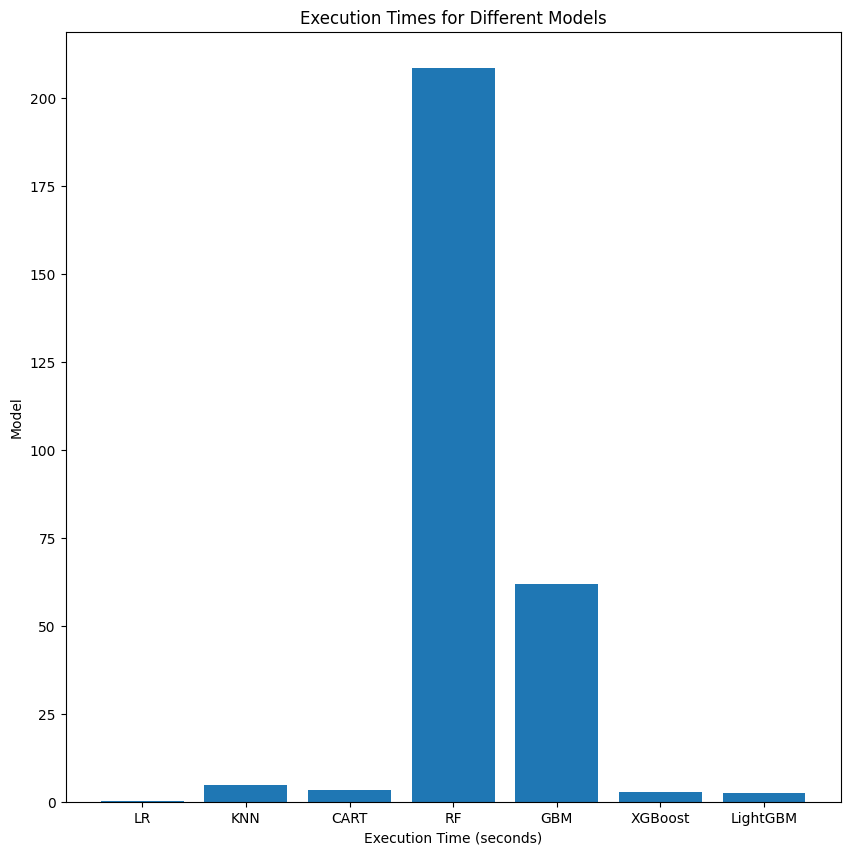

In [58]:
models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]

rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []

for name, regressor in models:
    start_time = time.time()

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    rmse_scores.append(rmse)
    
    r2 = metrics.r2_score(y_test, y_pred)
    r2_scores.append(r2)

    mae = metrics.mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    execution_time = time.time() - start_time
    execution_times.append(execution_time)
    
    print(f"RMSE: {round(rmse, 4)} ({name})")
    print(f"R^2 Score: {round(r2, 4)} ({name})")
    print(f"MAE: {round(mae, 4)} ({name})")
    print(f"Execution Time: {round(execution_time, 2)} seconds\n")

plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], rmse_scores)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Model Performance (RMSE)")
plt.show()

plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], r2_scores)
plt.xlabel("Model")
plt.ylabel("R^2 Score")
plt.title("Model Performance (R^2 Score)")
plt.show()

plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], mae_scores)
plt.xlabel("Model")
plt.ylabel("MAE")
plt.title("Model Performance (MAE)")
plt.show()

plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], execution_times)
plt.xlabel("Execution Time (seconds)")
plt.ylabel("Model")
plt.title("Execution Times for Different Models")
plt.show()

Results of Final Model Prediction:
        Predicted Price  True Price  Difference
2472           136.947         135      -1.947
34556           98.757         100       1.243
34771           41.832          39      -2.832
48617           78.847          80       1.153
11574          150.697         150      -0.697
...                ...         ...         ...
24079          361.196         375      13.804
39454          118.927         120       1.073
12582          220.494         220      -0.494
10308          200.821         200      -0.821
6586            78.847          80       1.153

[9779 rows x 3 columns]


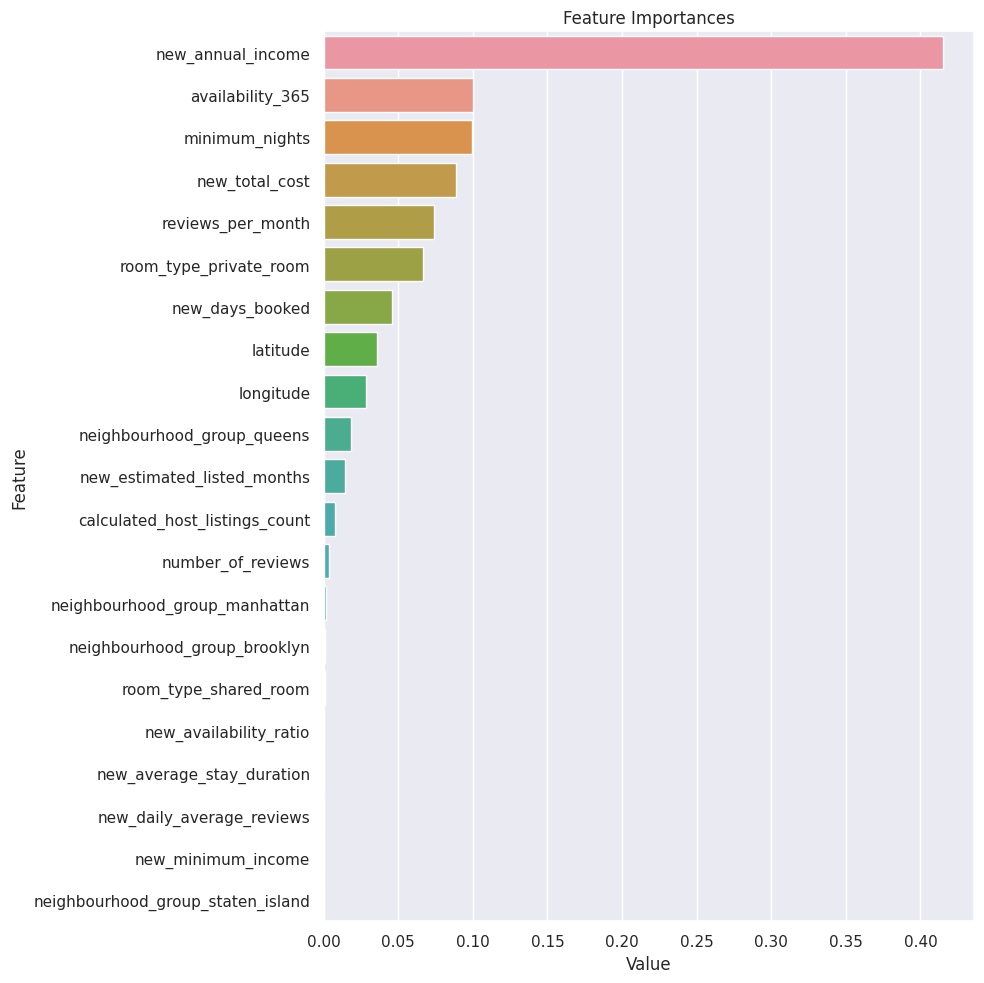

In [59]:
final_model = XGBRegressor()  
final_model.fit(X_train, y_train)
y_final_pred = final_model.predict(X_test)
final_y_pred = y_final_pred
final_y_test = y_test
results = pd.DataFrame({'Predicted Price': final_y_pred, 'True Price': final_y_test})
results['Difference'] = results['True Price'] - results['Predicted Price']
print("Results of Final Model Prediction:\n", results)
def plot_importance(model, features, num=50, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show(block=True)
plot_importance(final_model, X)